# Analysis of Optimal Retention

This notebook explores how to effectively determine optimal retention.

All simulations in this notebook start from a new collection and use the default parameters (and assume the default parameters accurately describe the forgetting curve for the simulated user).

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

REPEATS = int(os.getenv("REPEATS", "1"))
N_DAYS = int(os.getenv("N_DAYS", "180"))

## Current Approach
We run simulations with a range of target retentions and fixed new and review limits.

In [2]:
from anki_utils import (
    DEFAULT_PROB_EASY,
    DEFAULT_PROB_FIRST_AGAIN,
    DEFAULT_PROB_FIRST_EASY,
    DEFAULT_PROB_FIRST_GOOD,
    DEFAULT_PROB_FIRST_HARD,
    DEFAULT_PROB_GOOD,
    DEFAULT_PROB_HARD,
)
from simulate_fsrs import run_simulation
from simulation_config import SimulationConfig

print(
    "Probabilities for first card grading:"
    f"\n\tAgain: {int(100 * DEFAULT_PROB_FIRST_AGAIN)}%"
    f"\n\t Hard: {int(100 * DEFAULT_PROB_FIRST_HARD)}%"
    f"\n\t Good: {int(100 * DEFAULT_PROB_FIRST_GOOD)}%"
    f"\n\t Easy: {int(100 * DEFAULT_PROB_FIRST_EASY)}%"
)
print(
    "Probabilities given recall (Success):"
    f"\n\t Hard: {int(100 * DEFAULT_PROB_HARD)}%"
    f"\n\t Good: {int(100 * DEFAULT_PROB_GOOD)}%"
    f"\n\t Easy: {int(100 * DEFAULT_PROB_EASY)}%"
)

Probabilities for first card grading:
	Again: 50%
	 Hard: 10%
	 Good: 30%
	 Easy: 10%
Probabilities given recall (Success):
	 Hard: 10%
	 Good: 80%
	 Easy: 10%


Simulating ret=0.1...
Simulating ret=0.2...
Simulating ret=0.3...
Simulating ret=0.4...
Simulating ret=0.5...
Simulating ret=0.6...
Simulating ret=0.7...
Simulating ret=0.8...
Simulating ret=0.9...
Simulating ret=0.95...


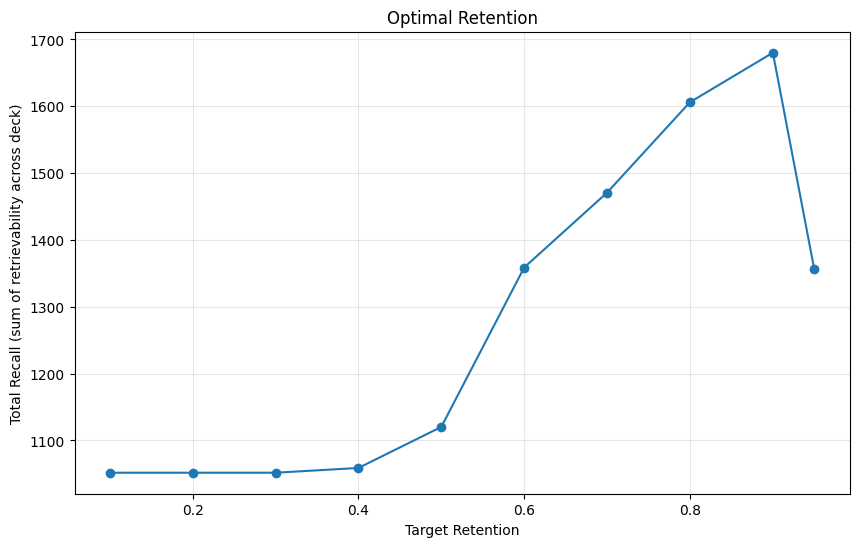

In [3]:
retentions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
metrics = []

for ret in retentions:
    print(f"Simulating ret={ret}...")
    config = SimulationConfig(
        n_days=N_DAYS,
        retention=str(ret),
        review_limit=100,
        new_limit=10,
        verbose=False,
        compute_final_params=False,
        return_logs=False,
    )
    _, _, sim_metrics = run_simulation(config)
    metrics.append(sim_metrics)

# Extract totals for plotting
totals = [m["total_retention"] for m in metrics]

plt.figure(figsize=(10, 6))
plt.plot(retentions, totals, marker="o")
plt.title("Optimal Retention")
plt.xlabel("Target Retention")
plt.ylabel("Total Recall (sum of retrievability across deck)")
plt.grid(True, alpha=0.3)
plt.show()

This leads to higher target retentions appearing optimal (up to a point).

However, this simulation is biased. Higher retentions have a much higher workload, biasing us towards high target retentions (until the target retention becomes so high that the extra work is actually counter productive, as is the case at 95% target retention).

In [4]:
{r: metrics[i]["review_count"] for i, r in enumerate(retentions)}

{0.1: 3009,
 0.2: 3009,
 0.3: 3009,
 0.4: 2992,
 0.5: 3475,
 0.6: 5315,
 0.7: 6781,
 0.8: 8811,
 0.9: 12665,
 0.95: 15779}

We can account for this by plotting total retention gained per review done:

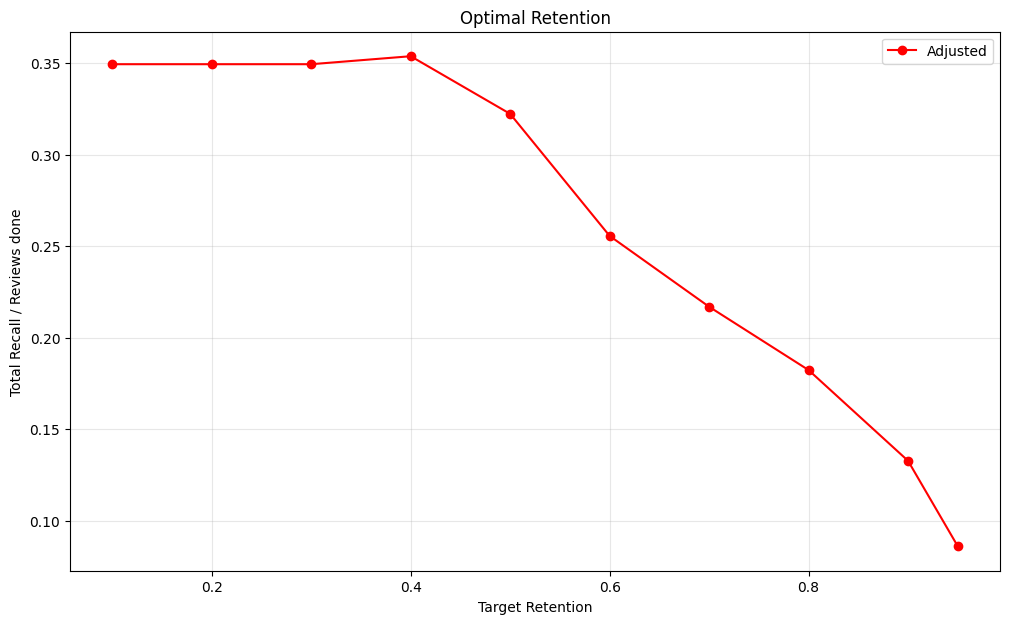

In [5]:
scaled_metrics = [m["total_retention"] / m["review_count"] for m in metrics]

# Plot Adjusted Curves
plt.figure(figsize=(12, 7))
plt.plot(retentions, scaled_metrics, marker="o", color="red", label="Adjusted")

plt.title("Optimal Retention")
plt.xlabel("Target Retention")
plt.ylabel("Total Recall / Reviews done")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

This chart now shows a bias towards lower target retentions.

## Fixed Workload Simulations 
It's easier to understand this bias by thinking about simulations where we fix each target retention to have the same workload (rather than allowing different workloads between them then scaling the results).

This is done by running simulations with a fixed review limit and an effectively unlimited new limit.

Simulating ret=0.1...
Simulating ret=0.2...
Simulating ret=0.3...
Simulating ret=0.4...
Simulating ret=0.5...
Simulating ret=0.6...
Simulating ret=0.7...
Simulating ret=0.8...
Simulating ret=0.9...
Simulating ret=0.95...


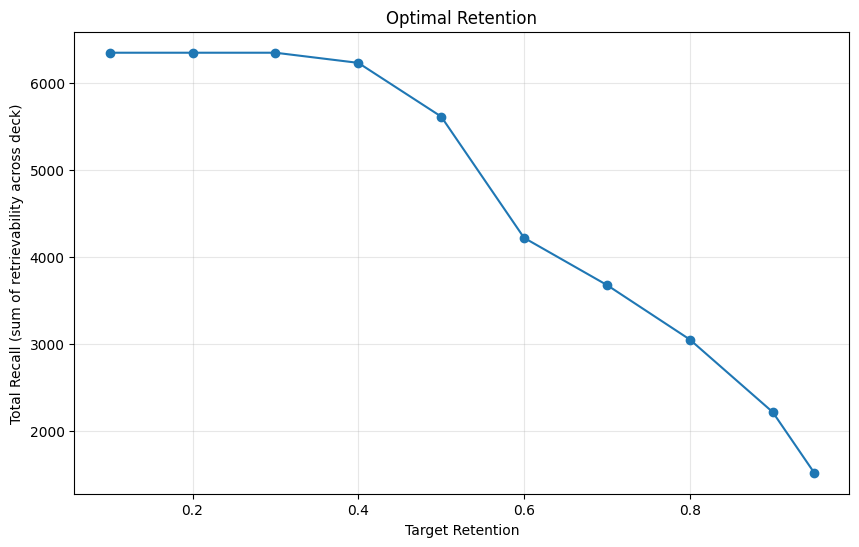

In [6]:
metrics = []

for ret in retentions:
    print(f"Simulating ret={ret}...")
    config = SimulationConfig(
        n_days=N_DAYS,
        retention=str(ret),
        review_limit=100,
        new_limit=9999,
        verbose=False,
        compute_final_params=False,
        return_logs=False,
    )
    _, _, sim_metrics = run_simulation(config)
    metrics.append(sim_metrics)

# Extract totals for plotting
totals = [m["total_retention"] for m in metrics]

plt.figure(figsize=(10, 6))
plt.plot(retentions, totals, marker="o")
plt.title("Optimal Retention")
plt.xlabel("Target Retention")
plt.ylabel("Total Recall (sum of retrievability across deck)")
plt.grid(True, alpha=0.3)
plt.show()

Lower target retentions (below 50% in the above plot) give higher target retention at the end of the simulation period.

At these low target retentions, intervals given after a review are longer than the simulation period, so the simulated user only ever sees new cards.

This graph looks very similar to the `Total Recall / Reviews done` plot above, as both are effectively scaling to a constant workload.

## Understanding Low Retention Bias
The total retention calculated across all of our simulations so far only takes into account the cards which have been seen at least once in that simulation, effectively labelling all unseen cards with a retention of zero. Reviewing an unseen card then gives a massive boost to this assumed zero retention which persists for a long time (the forgetting curve gradient is very small below around 70% retention).

This biases the optimization towards settings which lead to more reviews on previously unseen cards, which is expressed by optimal target retention being so low.

Zero retention for new cards is incorrect; we do not always grade new cards `AGAIN`. We can check historical review data to find the rate we mark new cards `AGAIN`, and that gives the average retention for unseen cards as `1 - P(AGAIN)`. For my decks this can be around 0.5.


## Fixing Low Retention Bias
"Fair" simulations must account for this latent knowledge across unseen cards. To do this, find the maximum number of cards seen across all simulations and pad the total retention of simulations with fewer seen cards with `ΔCards (1 - P(AGAIN))`.

In [7]:
# Calculate Adjusted Retention

# 1. Determine N_max (baseline population size)
max_cards = max(m["card_count"] for m in metrics)

# 2. Baseline retention for unseen cards
r_baseline = 1 - DEFAULT_PROB_FIRST_AGAIN


def get_adjusted_total(metrics_list, max_n, r_base):
    adjusted = []
    for m in metrics_list:
        # Current sum of retention for studied cards
        current_total = m["total_retention"]
        # Add hypothetical retention for cards we "could have" studied
        missing_cards = max_n - m["card_count"]
        # Ensure we don't subtract if a run somehow exceeded the max (unlikely)
        padding = max(0, missing_cards) * r_base
        adjusted.append(current_total + padding)
    return adjusted


adj_metrics = get_adjusted_total(metrics, max_cards, r_baseline)

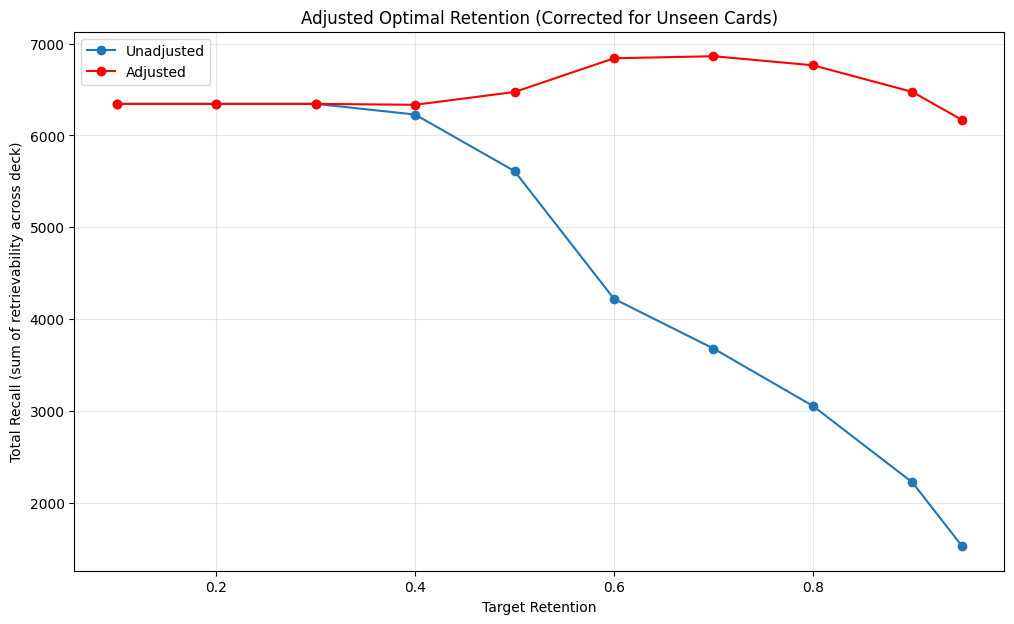

In [8]:
# Plot Adjusted Curves
plt.figure(figsize=(12, 7))
plt.plot(retentions, totals, marker="o", label="Unadjusted")
plt.plot(retentions, adj_metrics, marker="o", color="red", label="Adjusted")

# Highlight new optimals
opt_idx_c = np.argmax(totals)
opt_idx_l = np.argmax(adj_metrics)

plt.title("Adjusted Optimal Retention (Corrected for Unseen Cards)")
plt.xlabel("Target Retention")
plt.ylabel("Total Recall (sum of retrievability across deck)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()